In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import KNNImputer
import seaborn as sns
%matplotlib inline

In [6]:
cv19_cnty_dt =  pd.read_csv(r'covid-19/data/us-counties.csv')
county = pd.read_csv('covid-19/data/counties.csv')
intrvnt = pd.read_csv('covid-19/data/interventions.csv')
svi = pd.read_csv(r'covid-19/data/2018_CDC_SVI.csv')

In [7]:
cv19_cnty = cv19_cnty_dt.groupby(['state','county','fips'], as_index=False)[['date','cases','deaths']].max()
cv19_cnty.fips = cv19_cnty.fips.astype('int')
cv19_cnty = cv19_cnty.rename(columns={'fips':'FIPS'})
cv19_cnty.head()

,state,county,FIPS,date,cases,deaths
0,Alabama,Autauga,1001,2020-04-30,43,4
1,Alabama,Baldwin,1003,2020-04-30,174,3
2,Alabama,Barbour,1005,2020-04-30,39,1
3,Alabama,Bibb,1007,2020-04-30,42,0
4,Alabama,Blount,1009,2020-04-30,37,0


In [9]:
county['white']=county['NHWA_MALE'] + county['NHWA_FEMALE']

county['black']=county['NHBA_MALE'] + county['NHBA_FEMALE']

county['other_race']=county['NHIA_MALE'] + county['NHIA_FEMALE'] + county['NHAA_MALE'] + county['NHAA_FEMALE'] 
+ county['NHNA_MALE'] + county['NHNA_FEMALE'] + county['NHTOM_MALE'] + county['NHTOM_FEMALE']

county['hispanic'] = county['H_MALE'] + county['H_FEMALE']

county['percwhite'] = county['white']/county['POP_ESTIMATE_2018']*100
county['percblack'] = county['black']/county['POP_ESTIMATE_2018']*100
county['percother'] = county['other_race']/county['POP_ESTIMATE_2018']*100
county['perchisp'] = county['hispanic']/county['POP_ESTIMATE_2018']*100

county.loc[county['percblack'] > 50, 'blackCnty'] = 1
county.loc[county['percblack'] <= 50, 'blackCnty'] = 0

county.loc[county['perchisp'] > 50, 'HispCnty'] = 1
county.loc[county['perchisp'] <= 50, 'HispCnty'] = 0

county.columns

Index(['FIPS', 'State', 'Area_Name', 'Rural-urban_Continuum Code_2013',
       'Urban_Influence_Code_2013', 'Economic_typology_2015',
       'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'Births_2018', 'Deaths_2018',
       ...
       'white', 'black', 'other_race', 'hispanic', 'percwhite', 'percblack',
       'percother', 'perchisp', 'blackCnty', 'HispCnty'],
      dtype='object', length=357)

In [10]:
county = county.iloc[:,[0,1,2,6,55,111,112,113,116,119,122,248,312,329,347,348,349,350,351,352,353,354,355,356]]
county.head()

,FIPS,State,Area_Name,POP_ESTIMATE_2018,Median_Household_Income_2018,Total_Male,Total_Female,Total_age0to17,Total_age18to64,Total_age65plus,...,white,black,other_race,hispanic,percwhite,percblack,percother,perchisp,blackCnty,HispCnty
0,0,US,United States,327167434,61937.0,161128679.0,166038755.0,73399342.0,201336899.0,52431193.0,...,197487825.0,40898721.0,21142015.0,59722584.0,60.362923,12.500853,6.462139,18.254440,0.0,0.0
1,1000,AL,Alabama,4887871,49881.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,AL,Autauga County,55601,59338.0,26995.0,28606.0,13163.0,33785.0,8653.0,...,41316.0,10755.0,913.0,1649.0,74.308016,19.343177,1.642057,2.965774,0.0,0.0
3,1003,AL,Baldwin County,218022,57588.0,105657.0,112365.0,47110.0,126341.0,44571.0,...,181201.0,19151.0,3934.0,10131.0,83.111337,8.783976,1.804405,4.646779,0.0,0.0
4,1005,AL,Barbour County,24881,34382.0,13133.0,11748.0,5192.0,14857.0,4832.0,...,11356.0,11951.0,198.0,1064.0,45.641252,48.032635,0.795788,4.276355,0.0,0.0


In [11]:
county = county[~county['FIPS'].isin([0,1000,2000,4000,5000,6000,8000,9000,10000,11000,12000,13000,15000,16000,17000,
                                       18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,
                                       32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,42000,44000,45000,46000,
                                       47000,48000,49000,50000,51000,53000,54000,55000,56000,72000,
])]
county.shape

(3220, 24)

In [12]:
blackCnty = county[county['blackCnty'] == 1]

Text(0, 0.5, 'Number of Counties with mostly Black Population')

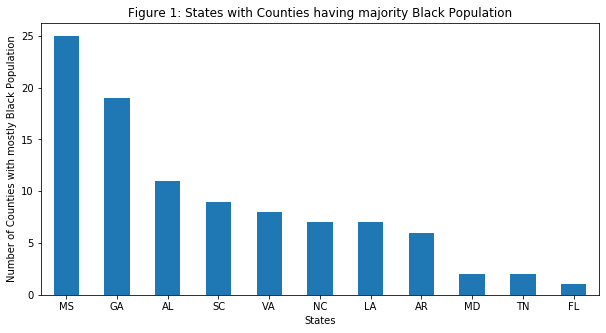

In [15]:
blackstate = pd.value_counts(blackCnty['State'].values, sort=True)
blackstate.plot.bar(figsize=(10,5), rot=0)
plt.title('Figure 1: States with Counties having majority Black Population')
plt.xlabel('States')
plt.ylabel('Number of Counties with mostly Black Population')

Text(0, 0.5, 'Number of USA Counties')

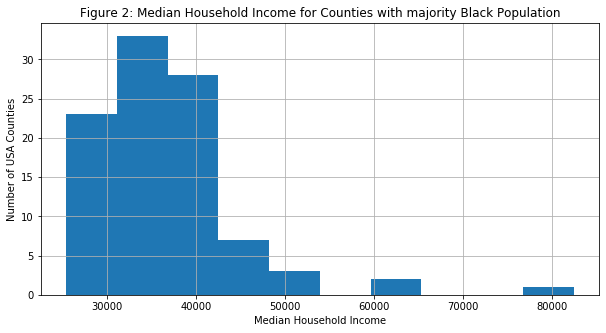

In [17]:
blackCnty['Median_Household_Income_2018'].hist(bins=10, figsize=(10,5))
plt.title('Figure 2: Median Household Income for Counties with majority Black Population')
plt.xlabel('Median Household Income')
plt.ylabel('Number of USA Counties')

In [18]:
blackCnty['Median_Household_Income_2018'].mean()

36302.113402061856

In [19]:
hispCnty = county[county['HispCnty'] == 1]

Text(0, 0.5, 'Number of Counties with mostly Hispanic Population')

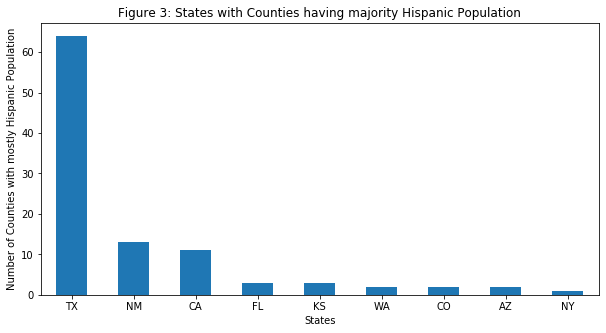

In [22]:
hispstate = pd.value_counts(hispCnty['State'].values, sort=True)
hispstate.plot.bar(figsize=(10,5), rot=0)
plt.title('Figure 3: States with Counties having majority Hispanic Population')
plt.xlabel('States')
plt.ylabel('Number of Counties with mostly Hispanic Population')

In [23]:
hispCnty['POP_ESTIMATE_2018'].mean()

177958.0099009901

Text(0, 0.5, 'Number of USA Counties')

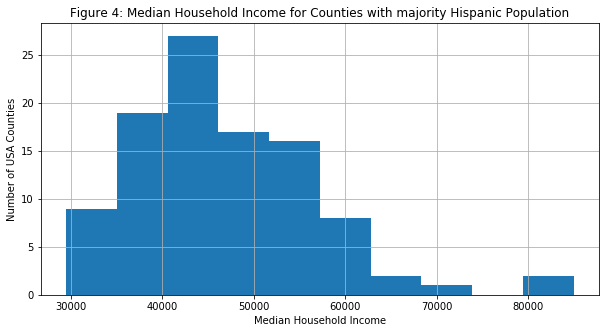

In [24]:
hispCnty['Median_Household_Income_2018'].hist(bins=10, figsize=(10,5))
plt.title('Figure 4: Median Household Income for Counties with majority Hispanic Population')
plt.xlabel('Median Household Income')
plt.ylabel('Number of USA Counties')

In [25]:
hispCnty['Median_Household_Income_2018'].mean()

46698.80198019802

In [26]:
county['Median_Household_Income_2018'].mean()

52794.413244189745

In [27]:
county['POP_ESTIMATE_2018'].mean()

102597.07670807453

In [28]:
svi.columns

Index(['FIPS', 'ST', 'STATE', 'ST_ABBR', 'COUNTY', 'FIPS.1', 'LOCATION',
       'AREA_SQMI', 'E_TOTPOP', 'M_TOTPOP',
       ...
       'F_CROWD', 'F_NOVEH', 'F_GROUPQ', 'F_THEME4', 'F_TOTAL', 'E_UNINSUR',
       'M_UNINSUR', 'EP_UNINSUR', 'MP_UNINSUR', 'E_DAYPOP'],
      dtype='object', length=124)

In [29]:
svi = svi.drop('FIPS', axis=1)
svi = svi.rename(columns={'FIPS.1':'FIPS'})

svi = svi[['FIPS','AREA_SQMI','E_TOTPOP','E_HU','E_HH','EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT',
           'EP_MINRTY','EP_LIMENG','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','EP_UNINSUR']].rename(columns={
    'AREA_SQMI':'area in square miles','E_TOTPOP':'Population','E_HU':'Housing units','E_HH':'Households','EP_POV':'below poverty %',
    'EP_UNEMP':'Unemployment Rate','EP_PCI':'Per capita income','EP_NOHSDP':'no high school diploma %','EP_AGE65':'Age 65 and older %',
    'EP_AGE17':'Age 17 and younger %','EP_DISABL':'Disabled %','EP_SNGPNT':'single parent households %','EP_MINRTY':'minority %', 
    'EP_MUNIT':'housing in structures with 10 or more units %','EP_UNINSUR':'Uninsured %','EP_LIMENG':'Limited English Speakers %',
    'EP_MOBILE':'Mobile Homes %','EP_NOVEH':'Households with no vehicle %','EP_GROUPQ':'Persons in Group Quarters %','EP_CROWD':'Crowded Houses %'
})

In [30]:
pd.set_option('display.max_columns', None)
svi.head()

,ST,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
0,1,ALABAMA,AL,Shelby,1117,"Shelby County, Alabama",785.375019,211261,0,86077,217,78328,781,17557,1471,4411,490,36576,787,11258,787,30125,103,50611,23,23579,1005,4696,443.0,46203,219.0,3147,559.0,6573,482.0,6867,403,875,192.0,2305,314,2989,392,8.4,0.7,4.0,0.4,36576.0,787.0,7.8,0.5,14.3,0.1,24.0,0.0,11.2,0.5,6.0,0.6,21.9,0.1,1.6,0.3,7.6,0.6,8.0,0.5,1.1,0.2,2.9,0.4,1.4,0.2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0606,0.8788,0.0000,0.0758,1.0152,0.0303,0.3030,0.8788,1.1818,0.6667,0.8939,0.0606,0.1818,0.0000,0.3788,1.5151,0.0758,3.7121,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14284,1203,6.8,0.6,186485
1,1,ALABAMA,AL,Baldwin,1003,"Baldwin County, Alabama",1589.793007,208107,0,111945,206,78622,1183,21653,1765,4343,620,31203,716,14310,1211,40665,69,45677,0,28863,1217,4508,581.0,35339,227.0,1068,323.0,20492,1203.0,13075,831,991,248.0,2705,443,3014,459,10.6,0.9,4.4,0.6,31203.0,716.0,9.7,0.8,19.5,0.1,21.9,0.0,14.0,0.6,5.7,0.7,17.0,0.1,0.5,0.2,18.3,1.1,11.7,0.7,1.3,0.3,3.4,0.6,1.4,0.2,0.0152,0.0455,0.0303,0.0455,0.1365,0.0152,0.7879,0.4242,0.0758,0.0606,1.3485,0.1212,0.2121,0.4091,0.6212,0.1970,1.0000,0.1515,0.3030,0.0303,0.3788,1.8636,0.1667,3.9698,0.0152,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,20864,1646,10.2,0.8,195677
2,1,ALABAMA,AL,St. Clair,1115,"St. Clair County, Alabama",631.603005,87306,0,36628,118,32172,526,11268,1559,2188,428,24861,842,9255,911,13891,84,19998,106,14055,965,2319,320.0,12197,25.0,391,223.0,619,234.0,8772,571,277,112.0,979,221,2200,289,13.2,1.8,5.3,1.1,24861.0,842.0,15.2,1.5,15.9,0.1,22.9,0.1,16.5,1.1,7.2,1.0,14.0,0.0,0.5,0.3,1.7,0.6,23.9,1.6,0.9,0.3,3.0,0.7,2.5,0.3,0.0455,0.1364,0.2424,0.2121,0.6364,0.0909,0.2121,0.6667,0.2727,0.1667,1.3182,0.1061,0.1212,0.4091,0.5303,0.1212,0.4697,0.6212,0.0909,0.0152,0.7121,1.9091,0.2121,4.3940,0.0303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7553,985,8.8,1.2,67607
3,1,ALABAMA,AL,Colbert,1033,"Colbert County, Alabama",592.744687,54495,0,26466,58,21799,445,8785,848,1397,286,24918,1055,6016,555,10502,73,11608,38,10086,520,1791,278.0,11630,35.0,175,127.0,587,147.0,2455,310,83,54.0,1322,244,436,83,16.3,1.6,5.9,1.2,24918.0,1055.0,15.6,1.4,19.3,0.1,21.3,0.1,18.7,1.0,8.2,1.3,21.3,0.1,0.3,0.2,2.2,0.6,9.3,1.2,0.4,0.3,6.1,1.1,0.8,0.2,0.2727,0.2879,0.2273,0.2576,1.0455,0.1818,0.7424,0.2879,0.5000,0.3939,1.9242,0.4697,0.2879,0.2121,0.5000,0.1061,0.5606,0.0909,0.0152,0.5000,0.0455,1.2122,0.0000,4.6819,0.0455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4353,552,8.1,1.0,56580
4,1,ALABAMA,AL,Madison,1089,"Madison County, Alabama",801.582971,357560,0,159299,251,145256,1161,45960,2425,10632,812,35526,579,21617,1023,51308,25,79195,33,46042,1701,11785,789.0,125445,339.0,3762,517.0,16210,995.0,7081,606,1939,339.0,7103,496,8842,548,13.2,0.7,5.8,0.4,35526.0,579.0,8.9,0.4,14.3,0.1,22.1,0.0,13.1,0.5,8.1,0.5,35.1,0.1,1.1,0.2,10.2,0.6,4.4,0.4,1.3,0.2,4.9,0.3,2.5,0.2,0.0455,0.2424,0.0152,0.0152,0.3183,0.0303,0.0606,0.4848,0.0303,0.

In [31]:
svi = svi.replace(-999, np.nan)

In [32]:
intrvnt.dtypes

FIPS                    int64
STATE                  object
AREA_NAME              object
stay at home          float64
>50 gatherings        float64
>500 gatherings       float64
public schools        float64
restaurant dine-in    float64
entertainment/gym     float64
federal guidelines    float64
foreign travel ban    float64
dtype: object

In [35]:
date_vars = intrvnt.select_dtypes(include=['float']).columns
for col in date_vars:
    intrvnt[col].mask(intrvnt[col] > 0, 1, inplace=True)

intrvnt = intrvnt.fillna(0)
    
for col in date_vars:
    intrvnt[col] = intrvnt[col].astype('int') 

intrvnt.head()

,FIPS,STATE,AREA_NAME,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban
0,0,US,united states,0,0,0,0,0,0,0,0
1,1000,AL,alabama,0,1,1,1,1,0,1,1
2,1001,AL,autauga county,0,1,1,1,1,0,1,1
3,1003,AL,baldwin county,0,1,1,1,1,0,1,1
4,1005,AL,barbour county,0,1,1,1,1,0,1,1


In [36]:
cvdf = county.merge(svi, on = 'FIPS', how = 'left').merge(intrvnt, on = 'FIPS', how = 'left').merge(cv19_cnty, on = 'FIPS', how = 'left')
cvdf.shape

(3220, 161)

In [37]:
pd.set_option("max_rows", None)
missing_data = np.sum(cvdf.isnull())
missing_data

FIPS                                                     0
State                                                    0
Area_Name                                                0
POP_ESTIMATE_2018                                        0
Median_Household_Income_2018                            79
Total_Male                                              78
Total_Female                                            78
Total_age0to17                                          78
Total_age18to64                                         78
Total_age65plus                                         78
Total_age85plusr                                        78
Active Physicians per 100000 Population 2018 (AAMC)     78
Total Hospitals (2019)                                  78
ICU Beds                                                78
white                                                   79
black                                                   79
other_race                                              

In [40]:
cvdf = cvdf.drop({'state','county','AREA_NAME'}, axis = 1)
cvdf['date'].fillna(method='ffill', inplace = True)
cvdf.fillna(value = {'cases' : 0, 'deaths' : 0}, inplace = True)
print ('average number of COVID-19 cases and Deaths in counties with more than 50% African American population')
print(cvdf.groupby(['blackCnty']).mean()[{'cases','deaths'}])
print(' ')
print ('average number of COVID-19 cases and Deaths in counties with more than 50% Hispanic population')
print(cvdf.groupby(['HispCnty']).mean()[{'cases','deaths'}])
print(' ')
print('average number of COVID-19 cases and Deaths across all USA counties')
print(cvdf[{'cases','deaths'}].mean())

average number of COVID-19 cases and Deaths in counties with more than 50% African American population
                cases     deaths
blackCnty                       
0.0        284.218791  14.260184
1.0        297.298969  14.360825
 
average number of COVID-19 cases and Deaths in counties with more than 50% Hispanic population
               cases     deaths
HispCnty                       
0.0       285.879934  14.503289
1.0       246.782178   7.039604
 
average number of COVID-19 cases and Deaths across all USA counties
cases     277.684472
deaths     13.913665
dtype: float64


Text(0, 0.5, 'Average Number of COVID-19 cases per County')

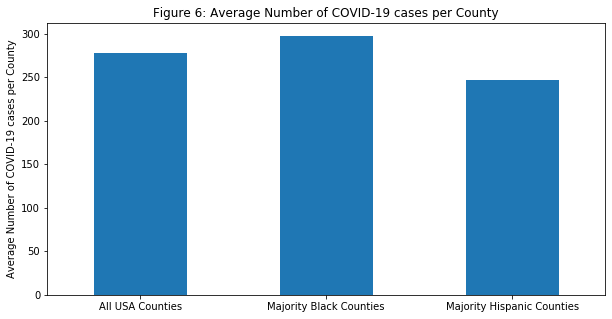

In [44]:
AvgCOVID = pd.DataFrame([cvdf['cases'].mean(),cvdf.loc[cvdf['blackCnty']==1, 'cases'].mean(),
                         cvdf.loc[cvdf['HispCnty']==1, 'cases'].mean(),],
                              index = ['All USA Counties','Majority Black Counties','Majority Hispanic Counties'])

AvgCOVID.plot.bar(figsize=(10,5), legend=False, rot=0)
plt.title('Figure 6: Average Number of COVID-19 cases per County')
plt.ylabel('Average Number of COVID-19 cases per County')

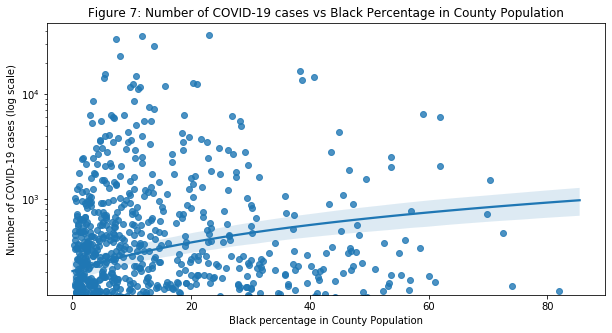

In [46]:
plt.figure(figsize=(10,5))
ax1 = sns.regplot(x='percblack',y='cases', data=cvdf)
plt.title('Figure 7: Number of COVID-19 cases vs Black Percentage in County Population')
plt.xlabel('Black percentage in County Population')
plt.ylabel('Number of COVID-19 cases (log scale)')
ax1.set_yscale('log')

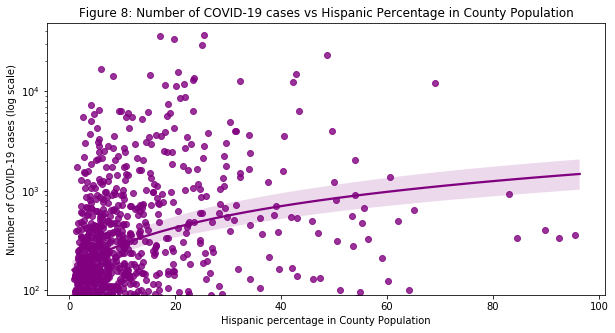

In [47]:
plt.figure(figsize=(10,5))
ax2 = sns.regplot(x='perchisp',y='cases', data=cvdf, color='purple')
plt.title('Figure 8: Number of COVID-19 cases vs Hispanic Percentage in County Population')
plt.xlabel('Hispanic percentage in County Population')
plt.ylabel('Number of COVID-19 cases (log scale)')
ax2.set_yscale('log')

In [60]:
cvdf['Med_HHInc_Percentile_rank']=cvdf.Median_Household_Income_2018.rank(pct=True)

cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.99) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0.90), 'Med_HHInc_Percentile'] = '90% - 99%'
cvdf.loc[cvdf['Med_HHInc_Percentile_rank'] >= 0.99, 'Med_HHInc_Percentile'] = '>=99%'
cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.90) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0.75), 'Med_HHInc_Percentile'] = '75% - 90%'
cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.75) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0.50), 'Med_HHInc_Percentile'] = '50% - 75%'
cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.50) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0.25), 'Med_HHInc_Percentile'] = '25% - 50%'
cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.25) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0), 'Med_HHInc_Percentile'] = '0% - 25%'

print ('average number of COVID-19 cases and Deaths by county median household income')
print(cvdf.groupby(['Med_HHInc_Percentile']).mean()[{'cases','deaths'}])

average number of COVID-19 cases and Deaths by county median household income
                            cases      deaths
Med_HHInc_Percentile                         
0% - 25%                51.107006    2.583439
25% - 50%              114.929936    6.645860
50% - 75%              148.968153    6.383439
75% - 90%              473.929936   22.664544
90% - 99%             1253.166078   64.063604
>=99%                 2156.187500  116.906250


In [58]:
cvdf['PCI_Percentile_rank']=cvdf['Per capita income'].rank(pct=True)

cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.99) & 
         (cvdf['PCI_Percentile_rank'] >= 0.90), 'PCI_Percentile'] = '90% - 99%'
cvdf.loc[cvdf['PCI_Percentile_rank'] >= 0.99, 'PCI_Percentile'] = '>=99%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.90) & 
         (cvdf['PCI_Percentile_rank'] >= 0.75), 'PCI_Percentile'] = '75% - 90%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.75) & 
         (cvdf['PCI_Percentile_rank'] >= 0.50), 'PCI_Percentile'] = '50% - 75%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.50) & 
         (cvdf['PCI_Percentile_rank'] >= 0.25), 'PCI_Percentile'] = '25% - 50%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.25) & 
         (cvdf['PCI_Percentile_rank'] >= 0), 'PCI_Percentile'] = '0% - 25%'

print ('average number of COVID-19 cases and Deaths by county Per capita income')
print(cvdf.groupby(['PCI_Percentile']).mean()[{'cases','deaths'}])

NameError: name 'cv19' is not defined

In [61]:
def cases_coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model1.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model1.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=True)
    return coefs_df

#Use the function
coef_df1 = cases_coef_weights(lm_model1.coef_, X1_train)
coef_df1 = coef_df1.drop('abs_coefs', axis=1).set_index('est_int')

#View the top results
coef_df = coef_df1.iloc[21:,:]
coef_df.plot.barh(width=1, figsize=(18,7), legend=False, color=[np.where(coef_df['coefs']>0, 'g', 'r')], rot=0)
plt.title('Figure 15: Most Influential coefficients in the linear model')
plt.axvline(0, color='k')
plt.ylabel(' ');


NameError: name 'lm_model1' is not defined

In [62]:
cvdf['PCI_Percentile_rank']=cvdf['EP_PCI'].rank(pct=True)

cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.99) & 
         (cvdf['PCI_Percentile_rank'] >= 0.90), 'PCI_Percentile'] = '90% - 99%'
cvdf.loc[cvdf['PCI_Percentile_rank'] >= 0.99, 'PCI_Percentile'] = '>=99%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.90) & 
         (cvdf['PCI_Percentile_rank'] >= 0.75), 'PCI_Percentile'] = '75% - 90%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.75) & 
         (cvdf['PCI_Percentile_rank'] >= 0.50), 'PCI_Percentile'] = '50% - 75%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.50) & 
         (cvdf['PCI_Percentile_rank'] >= 0.25), 'PCI_Percentile'] = '25% - 50%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.25) & 
         (cvdf['PCI_Percentile_rank'] >= 0), 'PCI_Percentile'] = '0% - 25%'

print ('average number of COVID-19 cases and Deaths by county Per capita income')
print(cvdf.groupby(['PCI_Percentile']).mean()[{'cases','deaths'}])

average number of COVID-19 cases and Deaths by county Per capita income
                      cases      deaths
PCI_Percentile                         
0% - 25%          43.456468    1.804726
25% - 50%         84.778882    4.734161
50% - 75%        161.920497    7.434783
75% - 90%        378.080745   16.447205
90% - 99%       1115.494810   57.598616
>=99%           4715.363636  271.666667


Text(0, 0.5, 'Average Number of COVID-19 cases')

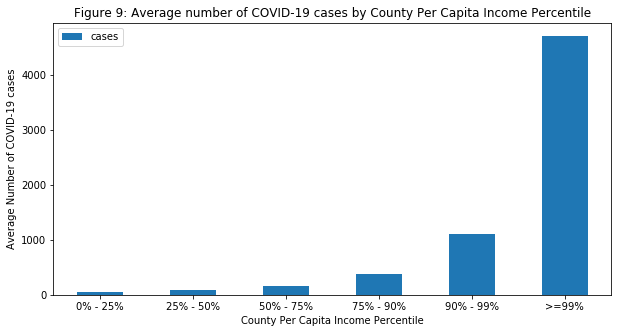

In [64]:
AvgCasesbyPCI = pd.DataFrame(cvdf.groupby(['PCI_Percentile']).mean()['cases']).reset_index()
AvgCasesbyPCI.plot.bar(x='PCI_Percentile',y='cases', figsize=(10,5), rot=0)
plt.title('Figure 9: Average number of COVID-19 cases by County Per Capita Income Percentile')
plt.xlabel('County Per Capita Income Percentile')
plt.ylabel('Average Number of COVID-19 cases')

Text(0, 0.5, 'Average Number of COVID-19 Deaths')

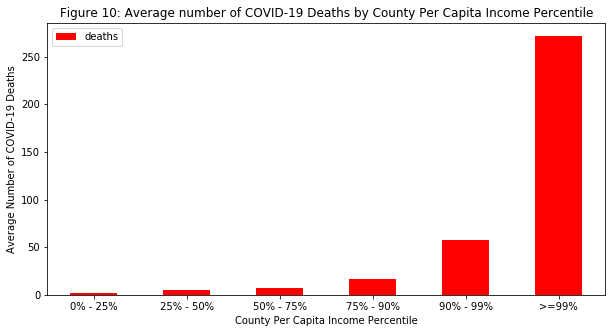

In [65]:
AvgDeathsbyPCI = pd.DataFrame(cvdf.groupby(['PCI_Percentile']).mean()['deaths']).reset_index()
AvgDeathsbyPCI.plot.bar(x='PCI_Percentile',y='deaths', color='r', figsize=(10,5), rot=0)
plt.title('Figure 10: Average number of COVID-19 Deaths by County Per Capita Income Percentile')
plt.xlabel('County Per Capita Income Percentile')
plt.ylabel('Average Number of COVID-19 Deaths')

In [66]:
HghMedHHI = cvdf[cvdf['Med_HHInc_Percentile_rank'] >= 0.99]
HghMedHHI = HghMedHHI.sort_values(by='Med_HHInc_Percentile_rank',ascending=False)
HghMedHHI.iloc[:,[0,1,2,3,4,30,53,54,55]].head()

,FIPS,State,Area_Name,POP_ESTIMATE_2018,Median_Household_Income_2018,E_TOTPOP,M_MINRTY,E_LIMENG,M_LIMENG
2872,51107,VA,Loudoun County,406850,140382.0,385143,414.0,13730,1049.0
2925,51610,VA,Falls Church city,14772,137551.0,14067,43.0,133,102.0
228,6085,CA,Santa Clara County,1937570,125933.0,1922200,800.0,162853,3483.0
1810,35028,NM,Los Alamos County,19101,124947.0,18356,22.0,119,102.0
206,6041,CA,Marin County,259666,122933.0,260295,544.0,9959,857.0


Text(0, 0.5, 'Number of Counties with the top 1% Median Household Income')

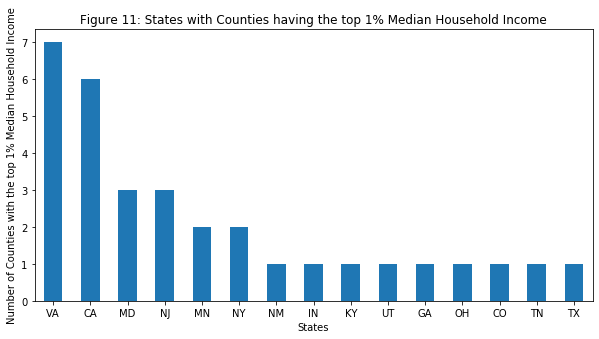

In [68]:
HghMedHHIstate = pd.value_counts(HghMedHHI['State'].values, sort=True)
HghMedHHIstate.plot.bar(figsize=(10,5), rot=0)
plt.title('Figure 11: States with Counties having the top 1% Median Household Income')
plt.xlabel('States')
plt.ylabel('Number of Counties with the top 1% Median Household Income')

In [69]:
HghPCI = cvdf[cvdf['PCI_Percentile_rank'] >= 0.99]
HghPCI = HghPCI.sort_values(by='PCI_Percentile_rank',ascending=False)
HghPCI.iloc[:,[0,1,2,3,4,30,53,54,57]].head()

,FIPS,State,Area_Name,POP_ESTIMATE_2018,Median_Household_Income_2018,E_TOTPOP,M_MINRTY,E_LIMENG,M_MUNIT
1858,36061,NY,New York County,1628701,84610.0,1632480,806.0,144058,4027.0
2925,51610,VA,Falls Church city,14772,137551.0,14067,43.0,133,190.0
206,6041,CA,Marin County,259666,122933.0,260295,544.0,9959,826.0
2826,51013,VA,Arlington County,237521,120950.0,231803,349.0,7884,1001.0
223,6075,CA,San Francisco County,883305,110601.0,870044,486.0,96657,1813.0


Text(0, 0.5, 'Number of Counties with the top 1% Per Capita Income')

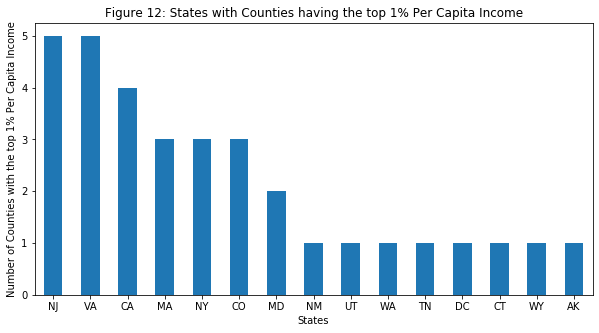

In [71]:
HghPCIstate = pd.value_counts(HghPCI['State'].values, sort=True)
HghPCIstate.plot.bar(figsize=(10,5), rot=0)
plt.title('Figure 12: States with Counties having the top 1% Per Capita Income')
plt.xlabel('States')
plt.ylabel('Number of Counties with the top 1% Per Capita Income')

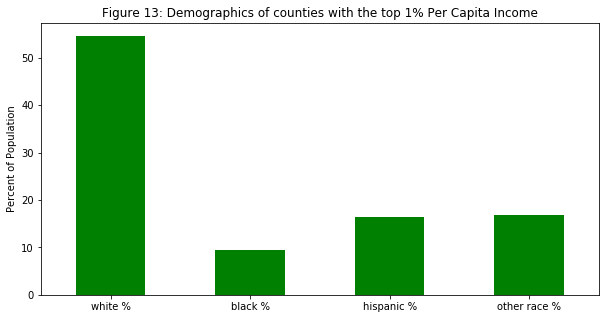

In [76]:
HghPCIdemo = pd.DataFrame([np.sum(HghPCI['white'])/np.sum(HghPCI['POP_ESTIMATE_2018'])*100,
                              np.sum(HghPCI['black'])/np.sum(HghPCI['POP_ESTIMATE_2018'])*100,
                              np.sum(HghPCI['hispanic'])/np.sum(HghPCI['POP_ESTIMATE_2018'])*100,
                              np.sum(HghPCI['other_race'])/np.sum(HghPCI['POP_ESTIMATE_2018'])*100],
                              index = ['white %','black %','hispanic %','other race %'])

HghPCIdemo.plot.bar(color='g', figsize=(10,5), legend=False, rot=0)
plt.title('Figure 13: Demographics of counties with the top 1% Per Capita Income')
plt.ylabel('Percent of Population');

In [78]:
HghMedHHI['POP_ESTIMATE_2018'].mean()

463117.6875

In [79]:
HghPCI['POP_ESTIMATE_2018'].mean()

623107.8181818182

In [80]:
HghMedHHI['Median_Household_Income_2018'].mean()

112714.34375

In [82]:
HghMedHHI['EP_PCI'].mean()

50929.875